## 1. Setup & Imports

In [2]:
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

## 2. Configuration

In [3]:
# Project paths
PROJECT_ROOT = Path(r"e:\container-id-research")
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
PREDICTIONS_JSON = PROJECT_ROOT / "data" / "interim" / "predictions_full.json"
OUTPUT_DIR = PROJECT_ROOT / "data" / "interim" / "processed_rois"

# Geometric thresholds
MIN_AREA_RATIO = 0.10  # 10% - Container too far/small
MAX_AREA_RATIO = 0.98  # 98% - Allow close-up shots (was 90%)
EDGE_TOUCH_THRESHOLD = 4  # Allow touching all 4 edges for close-ups (was 3)
EDGE_MARGIN = 5  # pixels - margin to consider "touching" edge

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Raw data directory: {RAW_DATA_DIR}")
print(f"Predictions file: {PREDICTIONS_JSON}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nGeometric Criteria:")
print(f"  Area ratio range: {MIN_AREA_RATIO:.0%} - {MAX_AREA_RATIO:.0%}")
print(f"  Max edge touches: {EDGE_TOUCH_THRESHOLD} edges (allows close-up shots)")

Raw data directory: e:\container-id-research\data\raw
Predictions file: e:\container-id-research\data\interim\predictions_full.json
Output directory: e:\container-id-research\data\interim\processed_rois

Geometric Criteria:
  Area ratio range: 10% - 98%
  Max edge touches: 4 edges (allows close-up shots)


## 3. Load Predictions

In [4]:
# Load predictions
with open(PREDICTIONS_JSON, "r", encoding="utf-8") as f:
    predictions = json.load(f)

print(f"Loaded {len(predictions)} predictions")
print(f"Sample prediction:")
print(json.dumps(predictions[0], indent=2))

Loaded 829 predictions
Sample prediction:
{
  "image_id": 65,
  "file_name": "0000065.jpg",
  "category_id": 1,
  "bbox": [
    49.0,
    0.0,
    1294.02,
    1521.06
  ],
  "score": 0.9442
}


## 4. Geometric Check Functions

In [5]:
def calculate_area_ratio(bbox: List[float], img_width: int, img_height: int) -> float:
    """
    Calculate the ratio of bounding box area to image area.

    Args:
        bbox: COCO format [x, y, width, height]
        img_width: Image width in pixels
        img_height: Image height in pixels

    Returns:
        Area ratio (0.0 to 1.0)
    """
    _, _, w, h = bbox
    bbox_area = w * h
    img_area = img_width * img_height
    return bbox_area / img_area if img_area > 0 else 0.0


def count_edge_touches(
    bbox: List[float], img_width: int, img_height: int, margin: int = 5
) -> int:
    """
    Count how many edges of the image the bounding box touches.

    Args:
        bbox: COCO format [x, y, width, height]
        img_width: Image width in pixels
        img_height: Image height in pixels
        margin: Pixel margin to consider "touching" (default: 5)

    Returns:
        Number of edges touched (0-4)
    """
    x, y, w, h = bbox
    x2 = x + w
    y2 = y + h

    touches = 0
    # Left edge
    if x <= margin:
        touches += 1
    # Top edge
    if y <= margin:
        touches += 1
    # Right edge
    if x2 >= img_width - margin:
        touches += 1
    # Bottom edge
    if y2 >= img_height - margin:
        touches += 1

    return touches


def check_geometry(
    bbox: List[float],
    img_width: int,
    img_height: int,
    min_ratio: float = 0.10,
    max_ratio: float = 0.90,
    max_edge_touches: int = 3,
) -> Tuple[bool, str, Dict[str, float]]:
    """
    Perform geometric check on bounding box.

    Args:
        bbox: COCO format [x, y, width, height]
        img_width: Image width in pixels
        img_height: Image height in pixels
        min_ratio: Minimum area ratio threshold
        max_ratio: Maximum area ratio threshold
        max_edge_touches: Maximum number of edges that can be touched

    Returns:
        Tuple of (passed, reason, metrics)
        - passed: True if passes all checks
        - reason: Rejection reason or "PASS"
        - metrics: Dict with area_ratio and edge_touches
    """
    area_ratio = calculate_area_ratio(bbox, img_width, img_height)
    edge_touches = count_edge_touches(bbox, img_width, img_height)

    metrics = {
        "area_ratio": area_ratio,
        "edge_touches": edge_touches,
    }

    # Check area ratio (too small)
    if area_ratio < min_ratio:
        return False, f"TOO_FAR (R={area_ratio:.1%} < {min_ratio:.0%})", metrics

    # Check area ratio (too large)
    if area_ratio > max_ratio:
        return False, f"TOO_CLOSE (R={area_ratio:.1%} > {max_ratio:.0%})", metrics

    # Check edge touches (cropped)
    if edge_touches >= max_edge_touches:
        return (
            False,
            f"CROPPED (touches {edge_touches}/{max_edge_touches} edges)",
            metrics,
        )

    return True, "PASS", metrics


# Test the functions
test_bbox = [100, 50, 800, 600]
test_width, test_height = 1920, 1080
ratio = calculate_area_ratio(test_bbox, test_width, test_height)
touches = count_edge_touches(test_bbox, test_width, test_height)
passed, reason, metrics = check_geometry(test_bbox, test_width, test_height)

print(f"Test BBox: {test_bbox}")
print(f"Image size: {test_width}x{test_height}")
print(f"Area ratio: {ratio:.2%}")
print(f"Edge touches: {touches}")
print(f"Result: {reason}")

Test BBox: [100, 50, 800, 600]
Image size: 1920x1080
Area ratio: 23.15%
Edge touches: 0
Result: PASS


## 5. Process All Images

In [6]:
results = []
pass_count = 0
reject_reasons = {}

print(f"Processing {len(predictions)} predictions...\n")

for pred in tqdm(predictions, desc="Geometric check"):
    file_name = pred["file_name"]
    bbox = pred["bbox"]
    score = pred["score"]

    # Load image to get dimensions
    img_path = RAW_DATA_DIR / file_name
    img = cv2.imread(str(img_path))

    if img is None:
        print(f"Warning: Could not read {file_name}")
        continue

    img_height, img_width = img.shape[:2]

    # Perform geometric check
    passed, reason, metrics = check_geometry(
        bbox,
        img_width,
        img_height,
        min_ratio=MIN_AREA_RATIO,
        max_ratio=MAX_AREA_RATIO,
        max_edge_touches=EDGE_TOUCH_THRESHOLD,
    )

    # Store result
    result = {
        "file_name": file_name,
        "image_size": (img_width, img_height),
        "bbox": bbox,
        "score": score,
        "passed": passed,
        "reason": reason,
        "area_ratio": metrics["area_ratio"],
        "edge_touches": metrics["edge_touches"],
    }
    results.append(result)

    # Count statistics
    if passed:
        pass_count += 1
    else:
        # Extract main reason (before parenthesis)
        main_reason = reason.split("(")[0].strip()
        reject_reasons[main_reason] = reject_reasons.get(main_reason, 0) + 1

print(f"\n✓ Geometric check complete!")
print(f"  Total images: {len(results)}")
print(f"  Passed: {pass_count} ({pass_count/len(results)*100:.1f}%)")
print(
    f"  Rejected: {len(results) - pass_count} ({(len(results)-pass_count)/len(results)*100:.1f}%)"
)

Processing 829 predictions...



Geometric check:   0%|          | 0/829 [00:00<?, ?it/s]


✓ Geometric check complete!
  Total images: 829
  Passed: 706 (85.2%)
  Rejected: 123 (14.8%)


## 6. Statistics & Analysis

In [7]:
print("\n=== Rejection Reasons ===")
for reason, count in sorted(reject_reasons.items(), key=lambda x: x[1], reverse=True):
    percentage = count / len(results) * 100
    print(f"  {reason}: {count} ({percentage:.1f}%)")


=== Rejection Reasons ===
  TOO_CLOSE: 123 (14.8%)


In [8]:
# Analyze area ratio distribution
area_ratios = [r["area_ratio"] for r in results]
passed_ratios = [r["area_ratio"] for r in results if r["passed"]]
rejected_ratios = [r["area_ratio"] for r in results if not r["passed"]]

print("\n=== Area Ratio Statistics ===")
print(f"All images:")
print(f"  Min:    {min(area_ratios):.2%}")
print(f"  Max:    {max(area_ratios):.2%}")
print(f"  Mean:   {np.mean(area_ratios):.2%}")
print(f"  Median: {np.median(area_ratios):.2%}")

if passed_ratios:
    print(f"\nPassed images:")
    print(f"  Min:    {min(passed_ratios):.2%}")
    print(f"  Max:    {max(passed_ratios):.2%}")
    print(f"  Mean:   {np.mean(passed_ratios):.2%}")
    print(f"  Median: {np.median(passed_ratios):.2%}")


=== Area Ratio Statistics ===
All images:
  Min:    10.85%
  Max:    100.00%
  Mean:   80.82%
  Median: 83.68%

Passed images:
  Min:    10.85%
  Max:    97.98%
  Mean:   77.54%
  Median: 80.40%


C:\Users\USER\AppData\Local\Temp\ipykernel_7128\3561644710.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


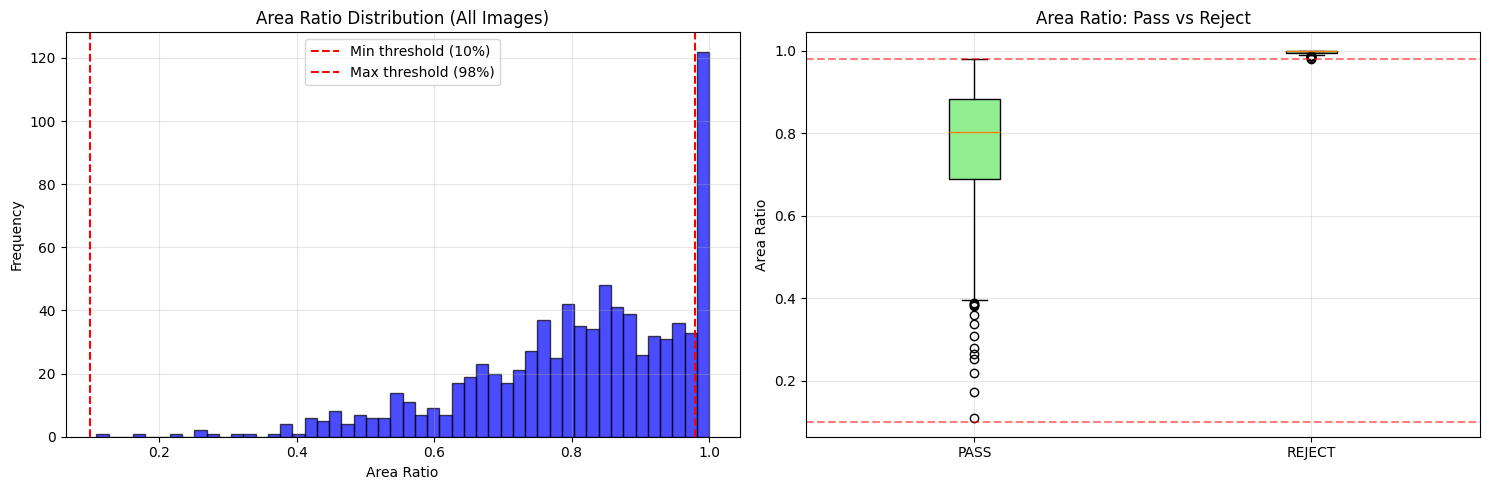

In [9]:
# Visualize area ratio distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of all area ratios
axes[0].hist(area_ratios, bins=50, alpha=0.7, color="blue", edgecolor="black")
axes[0].axvline(
    MIN_AREA_RATIO,
    color="red",
    linestyle="--",
    label=f"Min threshold ({MIN_AREA_RATIO:.0%})",
)
axes[0].axvline(
    MAX_AREA_RATIO,
    color="red",
    linestyle="--",
    label=f"Max threshold ({MAX_AREA_RATIO:.0%})",
)
axes[0].set_xlabel("Area Ratio")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Area Ratio Distribution (All Images)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
axes[1].boxplot(
    [passed_ratios, rejected_ratios],
    labels=["PASS", "REJECT"],
    patch_artist=True,
    boxprops=dict(facecolor="lightgreen"),
)
axes[1].axhline(MIN_AREA_RATIO, color="red", linestyle="--", alpha=0.5)
axes[1].axhline(MAX_AREA_RATIO, color="red", linestyle="--", alpha=0.5)
axes[1].set_ylabel("Area Ratio")
axes[1].set_title("Area Ratio: Pass vs Reject")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Crop & Save ROIs (Passed Images Only)

In [10]:
print(f"Cropping and saving {pass_count} passed images...\n")

crop_count = 0
for result in tqdm([r for r in results if r["passed"]], desc="Cropping ROIs"):
    file_name = result["file_name"]
    bbox = result["bbox"]

    # Load original image
    img_path = RAW_DATA_DIR / file_name
    img = cv2.imread(str(img_path))

    if img is None:
        continue

    # Extract bounding box coordinates
    x, y, w, h = bbox
    x1, y1 = int(x), int(y)
    x2, y2 = int(x + w), int(y + h)

    # Ensure coordinates are within image bounds
    img_height, img_width = img.shape[:2]
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_width, x2)
    y2 = min(img_height, y2)

    # Crop ROI
    roi = img[y1:y2, x1:x2]

    if roi.size == 0:
        print(f"Warning: Empty ROI for {file_name}")
        continue

    # Save cropped ROI
    output_path = OUTPUT_DIR / file_name
    cv2.imwrite(str(output_path), roi)
    crop_count += 1

print(f"\n✓ Cropping complete!")
print(f"  Cropped ROIs saved: {crop_count}")
print(f"  Output directory: {OUTPUT_DIR}")

Cropping and saving 706 passed images...



Cropping ROIs:   0%|          | 0/706 [00:00<?, ?it/s]


✓ Cropping complete!
  Cropped ROIs saved: 706
  Output directory: e:\container-id-research\data\interim\processed_rois


## 8. Visualize Sample Results

=== Sample PASS Images ===


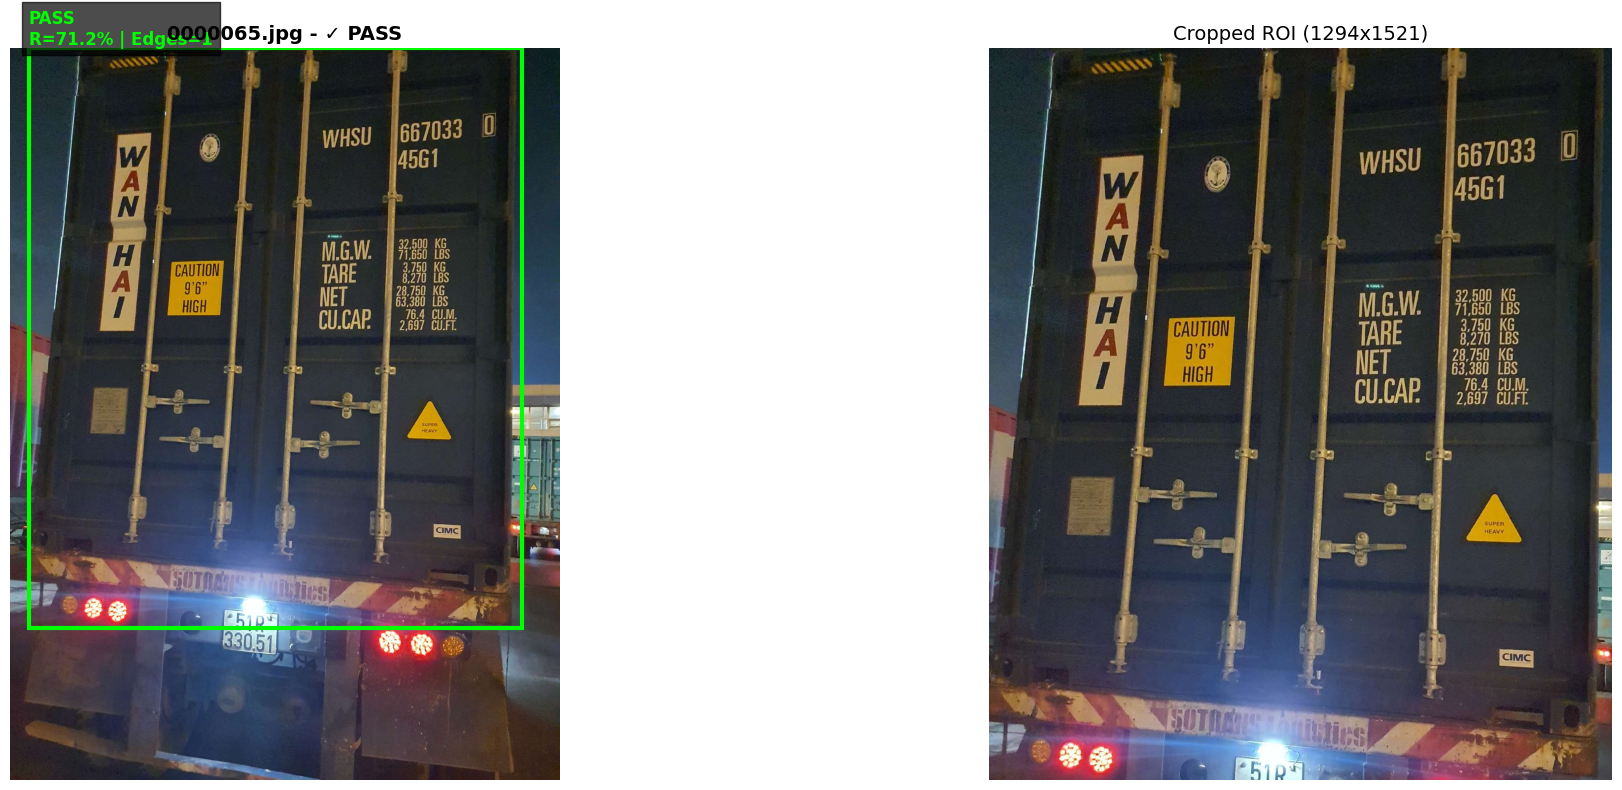

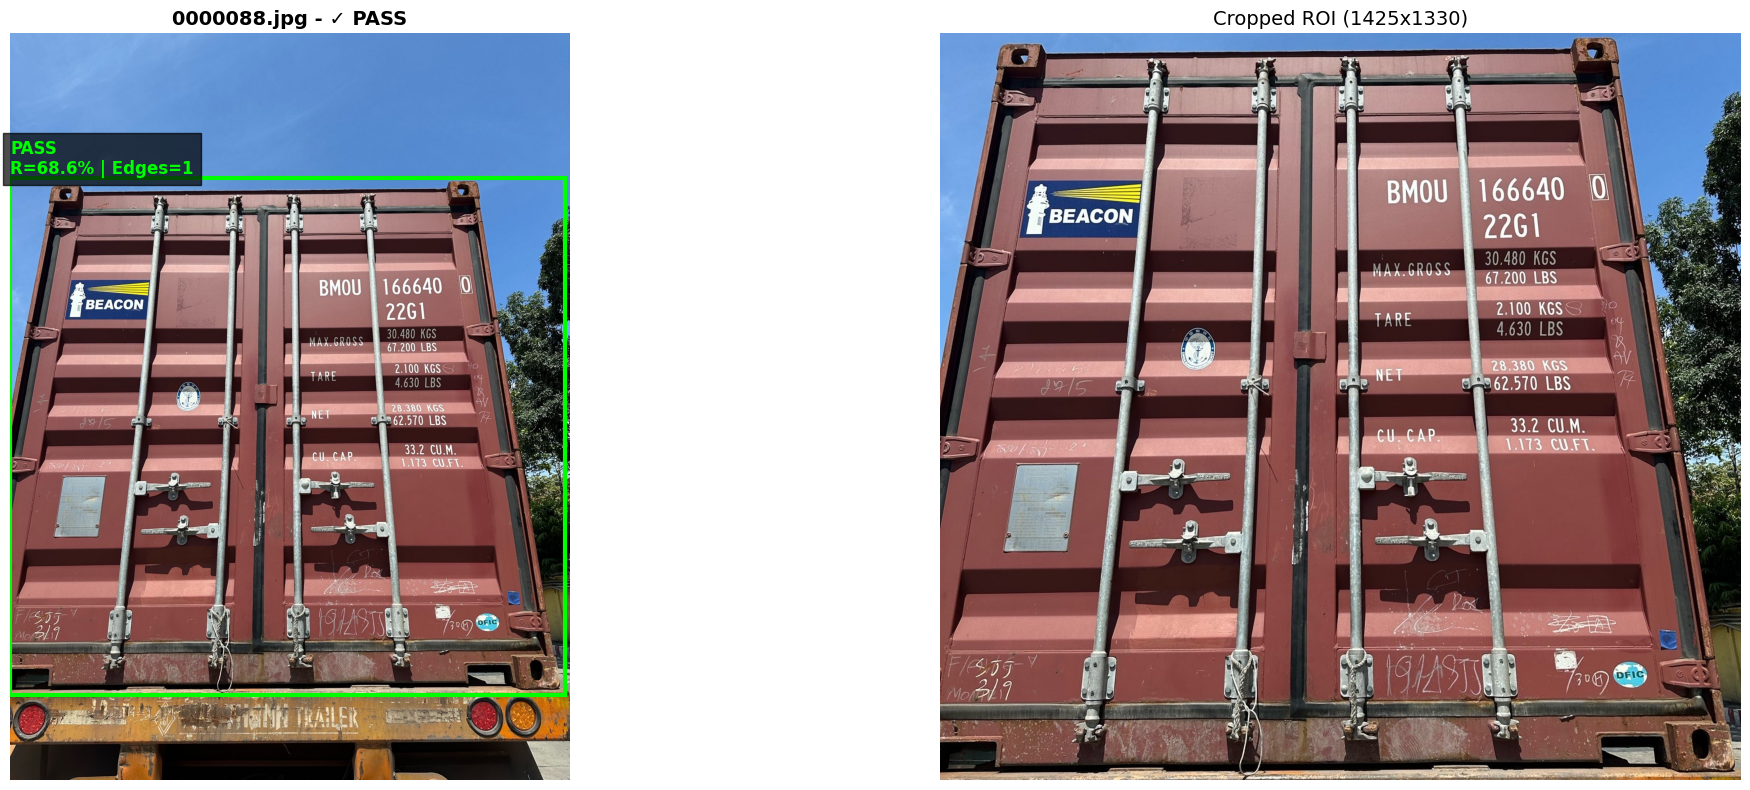

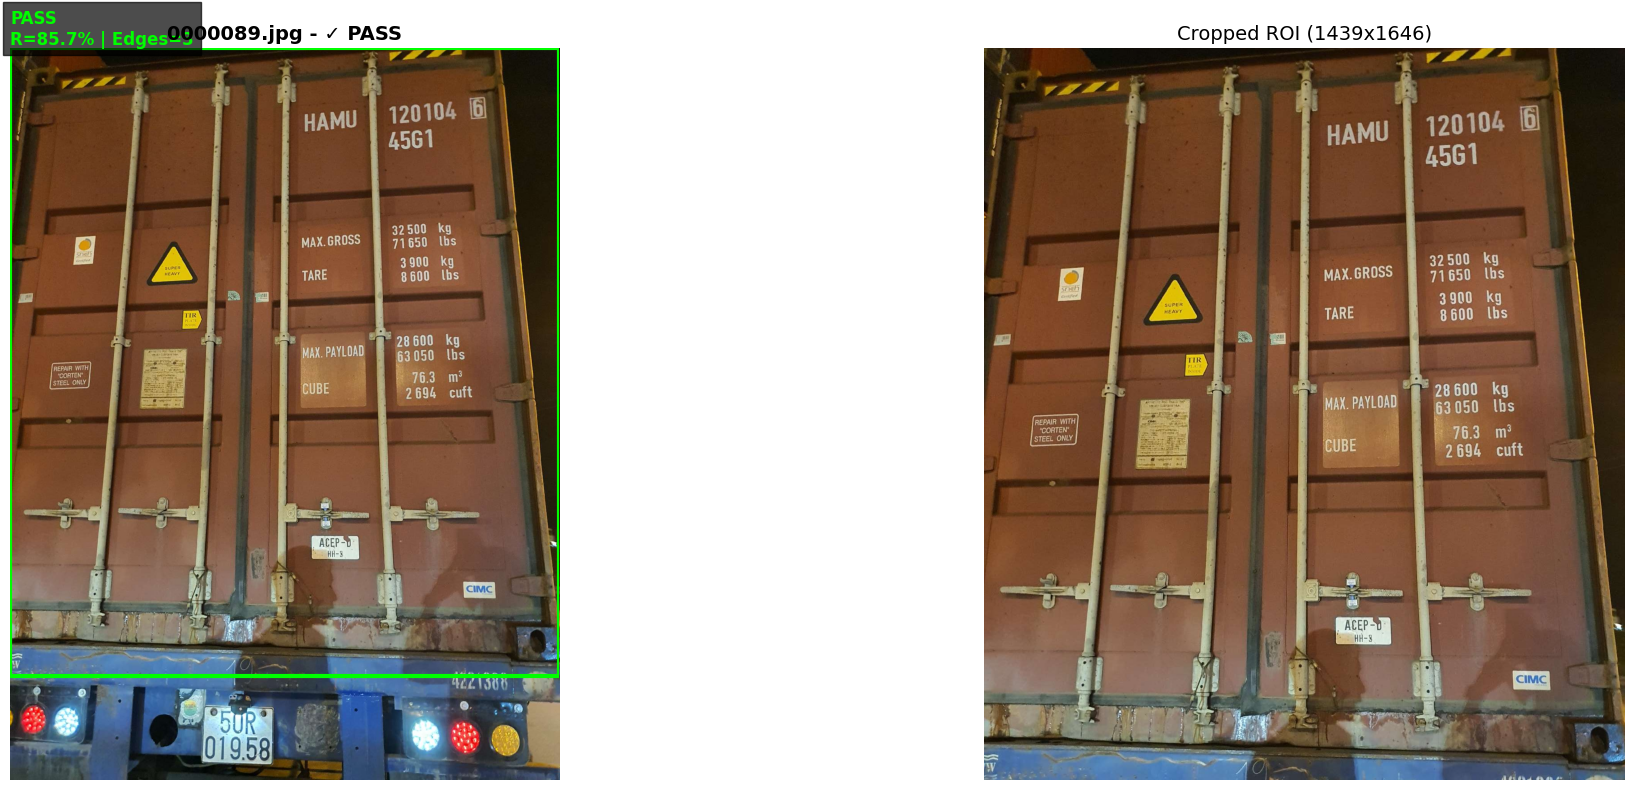

In [11]:
def visualize_geometric_check(result: Dict, show_crop: bool = True) -> None:
    """
    Visualize geometric check result with original image and optional crop.

    Args:
        result: Result dictionary from geometric check
        show_crop: Whether to show the cropped ROI (only for passed images)
    """
    file_name = result["file_name"]
    bbox = result["bbox"]
    passed = result["passed"]
    reason = result["reason"]
    area_ratio = result["area_ratio"]
    edge_touches = result["edge_touches"]

    # Load original image
    img_path = RAW_DATA_DIR / file_name
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Determine number of subplots
    n_plots = 2 if (passed and show_crop) else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(12 * n_plots, 8))

    if n_plots == 1:
        axes = [axes]

    # Plot 1: Original image with bbox
    axes[0].imshow(img_rgb)
    x, y, w, h = bbox

    # Color based on pass/reject
    color = "lime" if passed else "red"

    # Draw bounding box
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=3, edgecolor=color, facecolor="none"
    )
    axes[0].add_patch(rect)

    # Add label
    label_text = f"{reason}\nR={area_ratio:.1%} | Edges={edge_touches}"
    axes[0].text(
        x,
        y - 10,
        label_text,
        color=color,
        fontsize=12,
        fontweight="bold",
        bbox=dict(facecolor="black", alpha=0.7, pad=5),
    )

    status = "✓ PASS" if passed else "✗ REJECT"
    axes[0].set_title(f"{file_name} - {status}", fontsize=14, fontweight="bold")
    axes[0].axis("off")

    # Plot 2: Cropped ROI (only for passed images)
    if passed and show_crop:
        roi_path = OUTPUT_DIR / file_name
        if roi_path.exists():
            roi = cv2.imread(str(roi_path))
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            axes[1].imshow(roi_rgb)
            axes[1].set_title(
                f"Cropped ROI ({roi.shape[1]}x{roi.shape[0]})", fontsize=14
            )
            axes[1].axis("off")

    plt.tight_layout()
    plt.show()


# Show sample PASS images
print("=== Sample PASS Images ===")
passed_results = [r for r in results if r["passed"]]
for result in passed_results[:3]:
    visualize_geometric_check(result, show_crop=True)


=== Sample REJECT Images ===

Reason: TOO_CLOSE


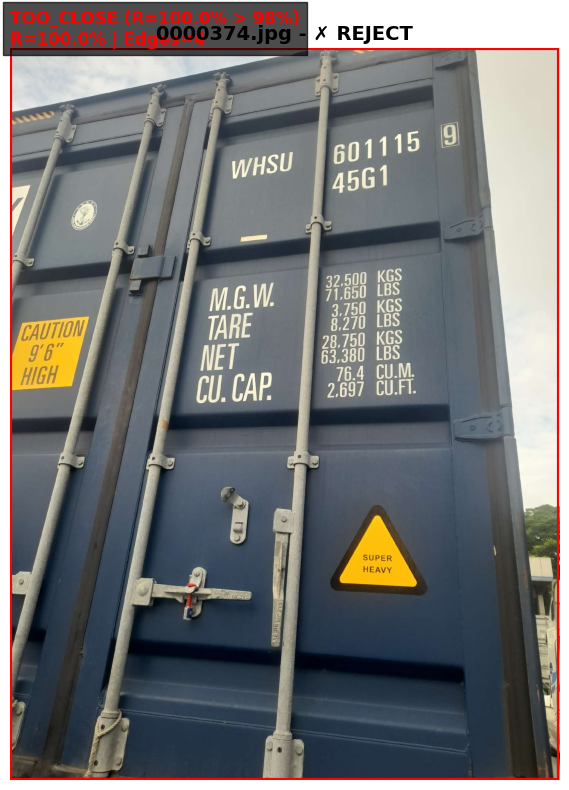

In [12]:
# Show sample REJECT images (one of each reason)
print("\n=== Sample REJECT Images ===")
reject_samples = {}
for result in results:
    if not result["passed"]:
        main_reason = result["reason"].split("(")[0].strip()
        if main_reason not in reject_samples:
            reject_samples[main_reason] = result

for reason, result in reject_samples.items():
    print(f"\nReason: {reason}")
    visualize_geometric_check(result, show_crop=False)

## 9. Save Results Report

In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame(results)

# Save to CSV
report_path = PROJECT_ROOT / "data" / "interim" / "geometric_check_report.csv"
df.to_csv(report_path, index=False)

print(f"✓ Report saved to: {report_path}")
print(f"\nReport preview:")
print(df.head(10))

✓ Report saved to: e:\container-id-research\data\interim\geometric_check_report.csv

Report preview:
     file_name    image_size                              bbox   score  \
0  0000065.jpg  (1440, 1920)     [49.0, 0.0, 1294.02, 1521.06]  0.9442   
1  0000088.jpg  (1440, 1920)   [0.0, 372.15, 1425.87, 1329.98]  0.9565   
2  0000089.jpg  (1440, 1920)      [0.2, 0.0, 1439.16, 1646.55]  0.9583   
3  0000155.jpg  (1440, 1920)    [2.14, 47.0, 1427.88, 1542.93]  0.9527   
4  0000160.jpg   (960, 1280)      [1.6, 2.53, 840.38, 1163.73]  0.9401   
5  0000164.jpg   (768, 1024)      [0.0, 151.03, 768.0, 872.93]  0.9436   
6  0000186.jpg  (1024, 1365)      [1.95, 0.0, 954.11, 1294.91]  0.9514   
7  0000204.jpg  (1440, 1920)  [4.09, 232.53, 1181.95, 1262.31]  0.9572   
8  0000267.jpg   (768, 1024)      [0.0, 20.73, 768.0, 1003.27]  0.9584   
9  0000287.jpg  (1440, 1920)    [32.02, 0.0, 1183.93, 1320.82]  0.9502   

   passed reason  area_ratio  edge_touches  
0    True   PASS    0.711908           

: 

## Summary

**Task 1 Complete** ✓

**Deliverables:**
- ✓ Geometric filtering based on area ratio and edge touches
- ✓ Cropped ROIs saved to `data/interim/processed_rois/`
- ✓ Statistical report: Pass/Reject counts and reasons
- ✓ CSV report: `geometric_check_report.csv`

**Statistics:**
- Total predictions analyzed: {len(results)}
- Passed geometric check: {pass_count}
- Rejected: {len(results) - pass_count}

**Next Step:**
- Proceed to **Task 2: Photometric Analysis**
- Use cropped ROIs from `processed_rois/` for brightness & contrast analysis